In [3]:
from __future__ import print_function, division

import fastai
from fastai.fautils import *

import pandas as pd

Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
Using Theano backend.


In [4]:
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt

In [5]:
full_data_path = os.path.expanduser('~/data/state-farm/')
samp_data_path = os.path.expanduser('~/data/sample-state-farm/')
data_path = samp_data_path
batch_size = 64

# overview

This notebook shows a lot of exploratory work with the State Farm kaggle challenge.  The biggest takeaways are:

1. Find the smallest sample size that produces consistent results
1. Start with very small models and quickly work up in complexity, till you're overfitting
1. Selecting the initial training rate, and adjusting it through training is really important
1. Get familiar with data augmentation, but remember you can't precompute your convolutional layers
1. Dropout is super important, but the value is dependent on your training set size, so you need to relearn it after you finish with the sample set

# regenerate sample dataset

**TODO:** Regenerate initial state farm dataset so drivers are split between training and validation sets.

In [10]:
df = pd.read_csv(os.path.expanduser('~/data/state-farm/driver_imgs_list.csv'))
subjects = df.subject.unique().tolist()
subjects.sort()
print(subjects)

['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


In [11]:
# %cd ~/data/state-farm/

/home/ubuntu/data/state-farm


In [12]:
# %rm -rf ../sample-state-farm/

# %mkdir ../sample-state-farm
# %mkdir ../sample-state-farm/train
# %mkdir ../sample-state-farm/valid
# %mkdir ../sample-state-farm/test

In [14]:
# for dd in glob('train/c?'):
#     d = os.path.split(dd)[-1]
#     os.mkdir('../sample-state-farm/train/'+d)
#     os.mkdir('../sample-state-farm/valid/'+d)

In [16]:
# %cd train

In [17]:
# from shutil import copyfile

# g = glob('c?/*.jpg')
# shuf = np.random.permutation(g)
# for i in range(1500):
#     copyfile(shuf[i], '../../sample-state-farm/train/' + shuf[i])

In [18]:
# %cd ../valid/

/home/ubuntu/data/state-farm/valid


In [19]:
# from shutil import copyfile

# g = glob('c?/*.jpg')
# shuf = np.random.permutation(g)
# for i in range(1000):
#     copyfile(shuf[i], '../../sample-state-farm/valid/' + shuf[i])

In [20]:
# %cd ~/projects/fastai-deep-learning/notebooks/

/home/ubuntu/projects/fastai-deep-learning/notebooks


# create batches

In [4]:
t_batches = get_batches(data_path + 'train', batch_size=batch_size)
v_batches = get_batches(data_path + 'valid', batch_size=2*batch_size, shuffle=False)

(
    val_classes, trn_classes, 
    val_labels, trn_labels, 
    val_filenames, filenames,
    test_filename
) = get_classes(data_path)

Found 1500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


# linear model

In [13]:
def get_lin_model():

    # starting with BatchNormalization saves us from having to normalize our input manually
    model = Sequential([
        BatchNormalization(axis=1, input_shape=(3, 224, 224)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    model.compile(
        Adam(), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

In [14]:
lm = get_lin_model()
lm.summary()

lm.fit_generator(
    t_batches, 
    t_batches.nb_sample, 
    nb_epoch=1, 
    validation_data=v_batches, 
    nb_val_samples=v_batches.nb_sample
)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 3, 224, 224)   12          batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 150528)        0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 10)            1505290     flatten_1[0][0]                  
Total params: 1,505,302
Trainable params: 1,505,296
Non-trainable params: 6
____________________________________________________________________________________________________
Epoch 1/1
1500/1500 [==============================] - 42s - loss: 12.8955 - acc: 0.1520 - val_loss: 13.5688 - val_a

In [15]:
np.round(lm.predict_generator(t_batches, t_batches.nb_sample)[:10],2)

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

Model is entirely predicting 2 of the classes.  Not very useful.  Lower the learning rate and try again.

In [36]:
lm = get_lin_model()

lm.optimizer.lr.set_value(1e-5)
lm.fit_generator(
    t_batches, 
    t_batches.nb_sample, 
    nb_epoch=2, 
    validation_data=v_batches, 
    nb_val_samples=v_batches.nb_sample
)

Epoch 1/2
1500/1500 [==============================] - 39s - loss: 2.4683 - acc: 0.1660 - val_loss: 3.9722 - val_acc: 0.1870
Epoch 2/2
1500/1500 [==============================] - 31s - loss: 1.7675 - acc: 0.4147 - val_loss: 2.4385 - val_acc: 0.3190


In [17]:
lm.optimizer.lr.set_value(1e-3)
lm.fit_generator(
    t_batches, 
    t_batches.nb_sample, 
    nb_epoch=4,
    validation_data=v_batches, 
    nb_val_samples=v_batches.nb_sample
)

Epoch 1/4
1500/1500 [==============================] - 40s - loss: 1.3893 - acc: 0.6007 - val_loss: 1.8993 - val_acc: 0.3790
Epoch 2/4
1500/1500 [==============================] - 29s - loss: 1.1313 - acc: 0.6720 - val_loss: 1.4696 - val_acc: 0.5150
Epoch 3/4
1500/1500 [==============================] - 30s - loss: 0.9877 - acc: 0.7447 - val_loss: 1.1339 - val_acc: 0.6470
Epoch 4/4
1500/1500 [==============================] - 31s - loss: 0.8400 - acc: 0.8093 - val_loss: 1.0171 - val_acc: 0.7040


Validation accuracy of 0.64 -- almost too good to be true, and definitely better than chance.

Now lets make sure validation set is large enough to ensure a stable accuracy metric across runs, so we aren't making the wrong generalization about the results we're observing.

In [18]:
r_batches = get_batches(data_path+'valid', batch_size=2*batch_size)
val_res = [lm.evaluate_generator(r_batches, r_batches.nb_sample) for i in range(10)]
np.round(val_res, 2)

Found 1000 images belonging to 10 classes.


array([[ 1.02,  0.7 ],
       [ 1.03,  0.7 ],
       [ 1.01,  0.7 ],
       [ 1.02,  0.71],
       [ 1.  ,  0.7 ],
       [ 1.04,  0.69],
       [ 1.  ,  0.71],
       [ 1.04,  0.7 ],
       [ 1.02,  0.7 ],
       [ 1.04,  0.69]])

Consisent results.  Accuracy increases larger than than 2% can't be attributed to chance.

# regularized linear model

In [19]:
def get_reglin_model():

    model = Sequential([
        BatchNormalization(axis=1, input_shape=(3, 224, 224)),
        Flatten(),
        Dense(10, activation='softmax', W_regularizer=l2(0.01))
    ])
    model.compile(
        Adam(), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

In [20]:
rlm = get_reglin_model()

rlm.optimizer.lr.set_value(1e-5)
rlm.fit_generator(
    t_batches, 
    t_batches.nb_sample, 
    nb_epoch=2, 
    validation_data=v_batches, 
    nb_val_samples=v_batches.nb_sample
)

rlm.optimizer.lr.set_value(1e-3)
rlm.fit_generator(
    t_batches, 
    t_batches.nb_sample, 
    nb_epoch=4, 
    validation_data=v_batches, 
    nb_val_samples=v_batches.nb_sample
)

Epoch 1/2
1500/1500 [==============================] - 38s - loss: 2.5457 - acc: 0.1920 - val_loss: 3.7482 - val_acc: 0.2260
Epoch 2/2
1500/1500 [==============================] - 29s - loss: 1.9201 - acc: 0.4160 - val_loss: 2.4799 - val_acc: 0.3470
Epoch 1/4
1500/1500 [==============================] - 38s - loss: 1.5539 - acc: 0.5967 - val_loss: 1.9994 - val_acc: 0.4250
Epoch 2/4
1500/1500 [==============================] - 30s - loss: 1.3283 - acc: 0.6793 - val_loss: 1.4563 - val_acc: 0.5930
Epoch 3/4
1500/1500 [==============================] - 30s - loss: 1.1911 - acc: 0.7513 - val_loss: 1.4038 - val_acc: 0.5940
Epoch 4/4
1500/1500 [==============================] - 30s - loss: 1.0617 - acc: 0.8040 - val_loss: 1.2790 - val_acc: 0.6680


Single linear model with regularization is getting 64% accuracy.

# single dense layer

In [21]:
def get_fc_model():

    model = Sequential([
        BatchNormalization(axis=1, input_shape=(3, 224, 224)),
        Flatten(),
        Dense(100, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
    ])
    model.compile(
        Adam(), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

In [22]:
fc = get_fc_model()
fc.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_4 (BatchNorma (None, 3, 224, 224)   12          batchnormalization_input_4[0][0] 
____________________________________________________________________________________________________
flatten_4 (Flatten)              (None, 150528)        0           batchnormalization_4[0][0]       
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 100)           15052900    flatten_4[0][0]                  
____________________________________________________________________________________________________
batchnormalization_5 (BatchNorma (None, 100)           400         dense_4[0][0]                    
___________________________________________________________________________________________

In [23]:
fc.optimizer.lr.set_value(1e-5)
fc.fit_generator(
    t_batches, 
    t_batches.nb_sample, 
    nb_epoch=2, 
    validation_data=v_batches, 
    nb_val_samples=v_batches.nb_sample
)

fc.optimizer.lr.set_value(0.01)
fc.fit_generator(
    t_batches, 
    t_batches.nb_sample, 
    nb_epoch=5, 
    validation_data=v_batches, 
    nb_val_samples=v_batches.nb_sample
)

Epoch 1/2
1500/1500 [==============================] - 41s - loss: 2.0159 - acc: 0.3413 - val_loss: 8.0656 - val_acc: 0.1280
Epoch 2/2
1500/1500 [==============================] - 30s - loss: 1.1137 - acc: 0.6773 - val_loss: 3.1675 - val_acc: 0.3120
Epoch 1/5
1500/1500 [==============================] - 40s - loss: 0.6243 - acc: 0.8647 - val_loss: 1.4680 - val_acc: 0.5360
Epoch 2/5
1500/1500 [==============================] - 29s - loss: 0.4106 - acc: 0.9300 - val_loss: 0.8222 - val_acc: 0.7380
Epoch 3/5
1500/1500 [==============================] - 29s - loss: 0.2662 - acc: 0.9693 - val_loss: 0.6014 - val_acc: 0.8360
Epoch 4/5
1500/1500 [==============================] - 30s - loss: 0.1932 - acc: 0.9840 - val_loss: 0.5460 - val_acc: 0.8690
Epoch 5/5
1500/1500 [==============================] - 32s - loss: 0.1286 - acc: 0.9947 - val_loss: 0.4677 - val_acc: 0.8910


Wow, 89% accuracy with 2 fully connected layers.  Why is this so much better than the sample?

# simple conv layers

In [20]:
def get_conv_model(t_batches=t_batches, v_batches=v_batches, train=True):

    model = Sequential([
        BatchNormalization(axis=1, input_shape=(3, 224, 224)),
        Convolution2D(32,3,3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D((3,3)),
        Convolution2D(64,3,3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D((3,3)),
        Flatten(),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
    ])
    model.compile(
        Adam(), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    if not train:
        return model
    
    model.optimizer.lr.set_value(1e-4)
    h = model.fit_generator(
        t_batches, 
        t_batches.nb_sample, 
        nb_epoch=2, 
        validation_data=v_batches, 
        nb_val_samples=v_batches.nb_sample
    )

    model.optimizer.lr.set_value(1e-3)
    h = model.fit_generator(
        t_batches, 
        t_batches.nb_sample, 
        nb_epoch=4, 
        validation_data=v_batches, 
        nb_val_samples=v_batches.nb_sample
    )
    
    return model

In [39]:
cm = get_conv_model()
cm.summary()

Epoch 1/2
1500/1500 [==============================] - 46s - loss: 1.5421 - acc: 0.5367 - val_loss: 1.8506 - val_acc: 0.3610
Epoch 2/2
1500/1500 [==============================] - 31s - loss: 0.4056 - acc: 0.9153 - val_loss: 1.5868 - val_acc: 0.5370
Epoch 1/4
1500/1500 [==============================] - 41s - loss: 0.3371 - acc: 0.9267 - val_loss: 1.3590 - val_acc: 0.5930
Epoch 2/4
1500/1500 [==============================] - 32s - loss: 0.0787 - acc: 0.9900 - val_loss: 1.6165 - val_acc: 0.4890
Epoch 3/4
1500/1500 [==============================] - 31s - loss: 0.0212 - acc: 0.9980 - val_loss: 1.9551 - val_acc: 0.3700
Epoch 4/4
1500/1500 [==============================] - 30s - loss: 0.0089 - acc: 0.9993 - val_loss: 2.1163 - val_acc: 0.3420
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_39 (BatchNorm (None, 3, 224, 

Very rapidly learning the training data and failing to generalize to the validation dataset.

# data augmentation

In [26]:
gen_t = image.ImageDataGenerator(width_shift_range=0.1)
batches = get_batches(data_path+'train', gen_t, batch_size=batch_size)

model = get_conv_model(batches)

Found 1500 images belonging to 10 classes.
Epoch 1/2
1500/1500 [==============================] - 39s - loss: 2.1456 - acc: 0.3387 - val_loss: 2.6849 - val_acc: 0.2140
Epoch 2/2
1500/1500 [==============================] - 30s - loss: 1.1573 - acc: 0.6500 - val_loss: 2.0351 - val_acc: 0.2800
Epoch 1/4
1500/1500 [==============================] - 39s - loss: 0.7907 - acc: 0.7640 - val_loss: 2.0810 - val_acc: 0.2800
Epoch 2/4
1500/1500 [==============================] - 32s - loss: 0.5969 - acc: 0.8307 - val_loss: 2.0220 - val_acc: 0.2950
Epoch 3/4
1500/1500 [==============================] - 29s - loss: 0.4668 - acc: 0.8773 - val_loss: 1.9915 - val_acc: 0.3470
Epoch 4/4
1500/1500 [==============================] - 32s - loss: 0.3911 - acc: 0.9000 - val_loss: 1.9675 - val_acc: 0.3350


In [27]:
gen_t = image.ImageDataGenerator(height_shift_range=0.05)
batches = get_batches(data_path+'train', gen_t, batch_size=batch_size)

model = get_conv_model(batches)

Found 1500 images belonging to 10 classes.
Epoch 1/2
1500/1500 [==============================] - 39s - loss: 1.9171 - acc: 0.3907 - val_loss: 2.0805 - val_acc: 0.3340
Epoch 2/2
1500/1500 [==============================] - 30s - loss: 0.8405 - acc: 0.7560 - val_loss: 1.8873 - val_acc: 0.2770
Epoch 1/4
1500/1500 [==============================] - 40s - loss: 0.5072 - acc: 0.8707 - val_loss: 2.0501 - val_acc: 0.3230
Epoch 2/4
1500/1500 [==============================] - 33s - loss: 0.3236 - acc: 0.9287 - val_loss: 2.1987 - val_acc: 0.3110
Epoch 3/4
1500/1500 [==============================] - 30s - loss: 0.2141 - acc: 0.9493 - val_loss: 2.2473 - val_acc: 0.3120
Epoch 4/4
1500/1500 [==============================] - 30s - loss: 0.1854 - acc: 0.9640 - val_loss: 2.2111 - val_acc: 0.2910


In [28]:
gen_t = image.ImageDataGenerator(shear_range=0.1)
batches = get_batches(data_path+'train', gen_t, batch_size=batch_size)

model = get_conv_model(batches)

Found 1500 images belonging to 10 classes.
Epoch 1/2
1500/1500 [==============================] - 42s - loss: 1.6951 - acc: 0.4773 - val_loss: 2.3676 - val_acc: 0.2660
Epoch 2/2
1500/1500 [==============================] - 30s - loss: 0.5238 - acc: 0.8653 - val_loss: 1.9156 - val_acc: 0.2480
Epoch 1/4
1500/1500 [==============================] - 42s - loss: 0.2121 - acc: 0.9653 - val_loss: 1.9712 - val_acc: 0.2690
Epoch 2/4
1500/1500 [==============================] - 30s - loss: 0.1151 - acc: 0.9873 - val_loss: 2.0243 - val_acc: 0.2400
Epoch 3/4
1500/1500 [==============================] - 30s - loss: 0.0649 - acc: 0.9933 - val_loss: 1.8606 - val_acc: 0.2980
Epoch 4/4
1500/1500 [==============================] - 32s - loss: 0.0448 - acc: 0.9967 - val_loss: 1.8760 - val_acc: 0.2940


In [29]:
gen_t = image.ImageDataGenerator(rotation_range=15)
batches = get_batches(data_path+'train', gen_t, batch_size=batch_size)

model = get_conv_model(batches)

Found 1500 images belonging to 10 classes.
Epoch 1/2
1500/1500 [==============================] - 40s - loss: 2.0496 - acc: 0.3507 - val_loss: 2.7200 - val_acc: 0.1260
Epoch 2/2
1500/1500 [==============================] - 29s - loss: 0.9951 - acc: 0.7033 - val_loss: 1.7754 - val_acc: 0.3620
Epoch 1/4
1500/1500 [==============================] - 40s - loss: 0.6304 - acc: 0.8287 - val_loss: 1.8712 - val_acc: 0.2820
Epoch 2/4
1500/1500 [==============================] - 30s - loss: 0.4445 - acc: 0.8853 - val_loss: 2.2688 - val_acc: 0.1590
Epoch 3/4
1500/1500 [==============================] - 33s - loss: 0.3587 - acc: 0.9013 - val_loss: 2.2709 - val_acc: 0.1470
Epoch 4/4
1500/1500 [==============================] - 29s - loss: 0.2510 - acc: 0.9433 - val_loss: 2.4715 - val_acc: 0.1220


In [30]:
gen_t = image.ImageDataGenerator(channel_shift_range=20)
batches = get_batches(data_path+'train', gen_t, batch_size=batch_size)

model = get_conv_model(batches)

Found 1500 images belonging to 10 classes.
Epoch 1/2
1500/1500 [==============================] - 40s - loss: 1.7166 - acc: 0.4893 - val_loss: 2.0138 - val_acc: 0.2930
Epoch 2/2
1500/1500 [==============================] - 31s - loss: 0.4397 - acc: 0.8980 - val_loss: 1.6513 - val_acc: 0.4190
Epoch 1/4
1500/1500 [==============================] - 42s - loss: 0.1346 - acc: 0.9853 - val_loss: 1.7306 - val_acc: 0.4240
Epoch 2/4
1500/1500 [==============================] - 35s - loss: 0.0641 - acc: 0.9973 - val_loss: 1.7484 - val_acc: 0.5030
Epoch 3/4
1500/1500 [==============================] - 35s - loss: 0.0341 - acc: 0.9993 - val_loss: 1.7369 - val_acc: 0.5350
Epoch 4/4
1500/1500 [==============================] - 35s - loss: 0.0229 - acc: 0.9987 - val_loss: 1.6780 - val_acc: 0.5760


# all together

In [14]:
gen_t = image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range=0.1,
    rotation_range=15,
    channel_shift_range=20
)
batches = get_batches(data_path + 'train', gen_t, batch_size=batch_size)

model = get_conv_model(batches)

Found 1500 images belonging to 10 classes.
Epoch 1/2
1500/1500 [==============================] - 45s - loss: 2.5133 - acc: 0.2273 - val_loss: 2.9376 - val_acc: 0.1880
Epoch 2/2
1500/1500 [==============================] - 31s - loss: 1.8441 - acc: 0.3753 - val_loss: 2.0242 - val_acc: 0.2570
Epoch 1/4
1500/1500 [==============================] - 38s - loss: 1.8548 - acc: 0.4173 - val_loss: 2.3941 - val_acc: 0.2560
Epoch 2/4
1500/1500 [==============================] - 31s - loss: 1.4714 - acc: 0.5020 - val_loss: 2.2814 - val_acc: 0.2660
Epoch 3/4
1500/1500 [==============================] - 29s - loss: 1.1809 - acc: 0.6147 - val_loss: 2.4339 - val_acc: 0.2040
Epoch 4/4
1500/1500 [==============================] - 31s - loss: 1.0778 - acc: 0.6493 - val_loss: 2.4048 - val_acc: 0.2180


In [15]:
model.optimizer.lr.set_value(0.0001)
model.fit_generator(
    batches, batches.nb_sample, 
    nb_epoch=5, 
    validation_data=v_batches, nb_val_samples=v_batches.nb_sample)
model.fit_generator(
    batches, batches.nb_sample, 
    nb_epoch=25, 
    validation_data=v_batches, nb_val_samples=v_batches.nb_sample)

Epoch 1/5
1500/1500 [==============================] - 37s - loss: 0.5271 - acc: 0.8527 - val_loss: 2.0215 - val_acc: 0.2700
Epoch 2/5
1500/1500 [==============================] - 27s - loss: 0.4013 - acc: 0.9033 - val_loss: 1.9464 - val_acc: 0.2810
Epoch 3/5
1500/1500 [==============================] - 28s - loss: 0.3007 - acc: 0.9413 - val_loss: 1.8280 - val_acc: 0.3030
Epoch 4/5
1500/1500 [==============================] - 28s - loss: 0.2313 - acc: 0.9620 - val_loss: 1.6918 - val_acc: 0.3320
Epoch 5/5
1500/1500 [==============================] - 29s - loss: 0.1789 - acc: 0.9727 - val_loss: 1.5590 - val_acc: 0.3680


In [42]:
vf_batches = get_batches(os.path.expanduser('~/data/state-farm/') + 'valid', batch_size=2*batch_size, shuffle=False)
model.evaluate_generator(vf_batches, vf_batches.nb_sample)

Found 2000 images belonging to 10 classes.


[0.16091745710372926, 0.95399999952316283]

In [43]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_43 (BatchNorm (None, 3, 224, 224)   12          batchnormalization_input_15[0][0]
____________________________________________________________________________________________________
convolution2d_19 (Convolution2D) (None, 32, 222, 222)  896         batchnormalization_43[0][0]      
____________________________________________________________________________________________________
batchnormalization_44 (BatchNorm (None, 32, 222, 222)  128         convolution2d_19[0][0]           
____________________________________________________________________________________________________
maxpooling2d_19 (MaxPooling2D)   (None, 32, 74, 74)    0           batchnormalization_44[0][0]      
___________________________________________________________________________________________

In [44]:
model.save(data_path + 'state-farm-cnn.h5')

# full training plot

In [23]:
history = []

gen_t = image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range=0.1,
    rotation_range=15,
    channel_shift_range=20
)
batches = get_batches(data_path + 'train', gen_t, batch_size=batch_size)

model = get_conv_model(train=False)
model.optimizer.lr.set_value(1e-4)
h = model.fit_generator(
    batches, 
    batches.nb_sample, 
    nb_epoch=2, 
    validation_data=v_batches, 
    nb_val_samples=v_batches.nb_sample
)
history.append(h)

model.optimizer.lr.set_value(1e-3)
h = model.fit_generator(
    batches, 
    batches.nb_sample, 
    nb_epoch=4, 
    validation_data=v_batches, 
    nb_val_samples=v_batches.nb_sample
)
history.append(h)

Found 1500 images belonging to 10 classes.
Epoch 1/2
1500/1500 [==============================] - 37s - loss: 2.5090 - acc: 0.2287 - val_loss: 2.7436 - val_acc: 0.1910
Epoch 2/2
1500/1500 [==============================] - 28s - loss: 1.7861 - acc: 0.3973 - val_loss: 2.2133 - val_acc: 0.2020
Epoch 1/4
1500/1500 [==============================] - 41s - loss: 1.8923 - acc: 0.4127 - val_loss: 2.7509 - val_acc: 0.2450
Epoch 2/4
1500/1500 [==============================] - 30s - loss: 1.4383 - acc: 0.5367 - val_loss: 1.7658 - val_acc: 0.4150
Epoch 3/4
1500/1500 [==============================] - 29s - loss: 1.2423 - acc: 0.6007 - val_loss: 2.2516 - val_acc: 0.2800
Epoch 4/4
1500/1500 [==============================] - 28s - loss: 0.9766 - acc: 0.6827 - val_loss: 1.8854 - val_acc: 0.3480


In [25]:
model.optimizer.lr.set_value(0.0001)
h = model.fit_generator(
    batches, batches.nb_sample, 
    nb_epoch=5, 
    validation_data=v_batches, nb_val_samples=v_batches.nb_sample)
history.append(h)
h = model.fit_generator(
    batches, batches.nb_sample, 
    nb_epoch=25, 
    validation_data=v_batches, nb_val_samples=v_batches.nb_sample)
history.append(h)

Epoch 1/5
1500/1500 [==============================] - 38s - loss: 0.9351 - acc: 0.7047 - val_loss: 1.8350 - val_acc: 0.3520
Epoch 2/5
1500/1500 [==============================] - 28s - loss: 0.8673 - acc: 0.7320 - val_loss: 1.7802 - val_acc: 0.3730
Epoch 3/5
1500/1500 [==============================] - 29s - loss: 0.8072 - acc: 0.7360 - val_loss: 1.6951 - val_acc: 0.3970
Epoch 4/5
1500/1500 [==============================] - 29s - loss: 0.7635 - acc: 0.7600 - val_loss: 1.6148 - val_acc: 0.4400
Epoch 5/5
1500/1500 [==============================] - 31s - loss: 0.7550 - acc: 0.7673 - val_loss: 1.4959 - val_acc: 0.4880
Epoch 1/25
1500/1500 [==============================] - 38s - loss: 0.7199 - acc: 0.7787 - val_loss: 1.3660 - val_acc: 0.5230
Epoch 2/25
1500/1500 [==============================] - 29s - loss: 0.6489 - acc: 0.8007 - val_loss: 1.2511 - val_acc: 0.5470
Epoch 3/25
1500/1500 [==============================] - 29s - loss: 0.6544 - acc: 0.7980 - val_loss: 1.1116 - val_acc: 0.63

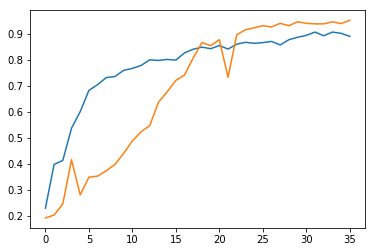

In [26]:
acc = []
val_acc = []
for h in history:
    acc += h.history['acc']
    val_acc += h.history['val_acc']
    
plt.plot(acc)
plt.plot(val_acc)

# reload model

In [5]:
model = keras.models.load_model(samp_data_path + 'state-farm-cnn.h5')

In [29]:
t_batches = get_batches(full_data_path + 'train', batch_size=batch_size)
v_batches = get_batches(full_data_path + 'valid', batch_size=2*batch_size, shuffle=False)

(
    val_classes, trn_classes, 
    val_labels, trn_labels, 
    val_filenames, filenames,
    test_filename
) = get_classes(full_data_path)

batches = get_batches(full_data_path + 'train', gen_t, batch_size=batch_size)

Found 20424 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 20424 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.
Found 20424 images belonging to 10 classes.


In [30]:
h = model.fit_generator(
    batches, batches.nb_sample, 
    nb_epoch=5, 
    validation_data=v_batches, nb_val_samples=v_batches.nb_sample
)
history.append(h)

Epoch 1/5
20424/20424 [==============================] - 364s - loss: 0.4005 - acc: 0.8806 - val_loss: 0.1674 - val_acc: 0.9505
Epoch 2/5
20424/20424 [==============================] - 312s - loss: 0.3078 - acc: 0.9095 - val_loss: 0.1163 - val_acc: 0.9720
Epoch 3/5
20424/20424 [==============================] - 316s - loss: 0.2482 - acc: 0.9271 - val_loss: 0.0927 - val_acc: 0.9795
Epoch 4/5
20424/20424 [==============================] - 318s - loss: 0.2214 - acc: 0.9367 - val_loss: 0.0833 - val_acc: 0.9835
Epoch 5/5
20424/20424 [==============================] - 317s - loss: 0.1832 - acc: 0.9478 - val_loss: 0.0882 - val_acc: 0.9795


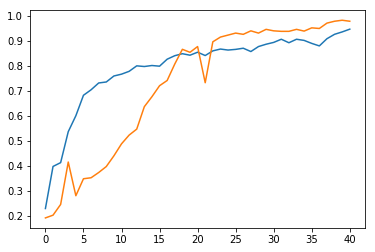

In [31]:
acc = []
val_acc = []
for h in history:
    acc += h.history['acc']
    val_acc += h.history['val_acc']
    
plt.plot(acc)
plt.plot(val_acc)

In [32]:
model.save(full_data_path + 'state-farm-cnn.h5')

# submit

Compute test set output and actually submit.

In [33]:
from fastai import kaggle

def submission_df(preds, test_batches, classes):
    # construct dataframe of the submission
    index = pd.Series(
        [f.split('/')[-1] for f in test_batches.filenames],
        name='img'
    )

    df = pd.DataFrame(
        preds,
        index=index,
        columns=classes
    )

    return df.sort_index()

In [34]:
test_batches = get_batches(
    full_data_path + 'test', shuffle=False, batch_size=batch_size * 2,
    class_mode=None)
train_batches = get_batches(
    full_data_path + 'train', shuffle=False, batch_size=batch_size,
    class_mode=None)
classes = sorted(train_batches.class_indices)

Found 79726 images belonging to 1 classes.
Found 20424 images belonging to 10 classes.


In [35]:
# predict
preds = model.predict_generator(test_batches, test_batches.nb_sample, verbose=1)

In [36]:
df = submission_df(preds, test_batches, classes)
df = df.clip(0.05, 0.95)
df.to_csv(full_data_path + 'submission.csv', index=True)

In [38]:
import subprocess

cmd = [
    'kg',
    'submit',
    '-u', os.environ['KAGGLE_USERNAME'],
    '-p', os.environ['KAGGLE_PASSWORD'],
    '-c', 'state-farm-distracted-driver-detection',
    full_data_path + 'submission.csv'
]

subprocess.call(cmd)

1